# NER and Image Verification - Demo
This notebook will demonstrate how to use the multimodal pipeline to verify text-based animal recognition with an image classifier. The pipeline extracts animal entities from a given text and matches them with a classified image.

In [13]:
import torch
import json
from IPython.display import display
from PIL import Image
import torchvision.transforms as transforms

import sys
import os

sys.path.append(os.path.abspath("src"))
from src.image_classifier_model import ImageClassifier
from src.ner_model import NERModel
from src.pipeline import MultimodalPipeline

## Step 2: Load Pre-Trained Models
We initialize the `MultimodalPipeline` with pre-trained Named Entity Recognition (NER) and Image Classification models.

Ensure that:
- The NER model is trained and stored in `models/ner_model`
- The image classifier model is saved in `models/classifier_model.pth`
- The class mapping file exists at `models/classifier_model_class_map.json`


In [14]:
# Define paths to trained models
ner_model_path = "models/ner_model"
classifier_model_path = "models/classifier_model/classifier_model.pth"
class_map_path = "models/classifier_model/classifier_model_class_map.json"

# Initialize the multimodal pipeline
pipeline = MultimodalPipeline(
    ner_model_path=ner_model_path,
    classifier_model_path=classifier_model_path,
    class_map_path=class_map_path
)

print("✅ Pipeline initialized successfully!")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!
✅ Loaded class mapping from models/classifier_model/classifier_model_class_map.json
✅ Model loaded successfully!
✅ Pipeline initialized successfully!


## Step 3: Display Model Metadata (Architecture, Parameters, Classes, Metrics)

In [15]:
# Load the NER model
ner_model = NERModel(data_path=None, model_save_path="models/ner_model")
ner_model.load_trained_model()

# Load the image classifier
classifier = ImageClassifier(data_dir='data/raw-img', model_save_path="models/classifier_model/classifier_model.pth")
classifier.load_trained_model()

# Display NER model metadata
print("🔍 Named Entity Recognition (NER) Model:")
print(f"- Model Learning rate: {ner_model.learning_rate}")
print(f"- Model batch size: {ner_model.batch_size}")
print(f"- Model number of epochs: {ner_model.epochs}")

# Display Image Classifier metadata
print("\n🖼 Image Classification Model:")
# Load class mapping
with open(classifier.class_map_path, "r") as f:
    class_to_idx = json.load(f)
idx_to_class = {v: k for k, v in class_to_idx.items()}
print(f"- Model Learning rate: {classifier.learning_rate}")
print(f"- Model batch size: {classifier.batch_size}")
print(f"- Model number of epochs: {classifier.epochs}")
print(f"- Classes: {idx_to_class}")

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!
✅ Model loaded successfully!
🔍 Named Entity Recognition (NER) Model:
- Model Learning rate: 5e-05
- Model batch size: 16
- Model number of epochs: 3

🖼 Image Classification Model:
- Model Learning rate: 0.001
- Model batch size: 32
- Model number of epochs: 15
- Classes: {0: 'butterfly', 1: 'cat', 2: 'chicken', 3: 'cow', 4: 'dog', 5: 'elephant', 6: 'horse', 7: 'sheep', 8: 'spider', 9: 'squirrel'}


### 📊 Named Entity Recognition (NER) Model Performance
Below are the evaluation metrics (Precision, Recall, and F1-score) for the trained NER model.


In [16]:
# Load and display NER model evaluation results
ner_model.evaluate_predictions()


📊 Evaluation Results:
              precision    recall  f1-score   support

    B-ANIMAL     1.0000    1.0000    1.0000        94
           O     1.0000    1.0000    1.0000       903

    accuracy                         1.0000       997
   macro avg     1.0000    1.0000    1.0000       997
weighted avg     1.0000    1.0000    1.0000       997



### 📸 Image Classification Model Performance
Below are the accuracy metrics for the trained image classifier model.


In [17]:
# Evaluate the image classifier model on the valid set
classifier.load_data()

classifier.evaluate_model()

✅ Model Accuracy on Validation Set: 91.52%


## Step 4: Provide Input Text and Image
To test the pipeline, provide:
1. A text containing the name of an animal.
2. The corresponding image of an animal.

📌 Example:
- **Text:** `"I saw a beautiful cat in the picture."`
- **Image:** `"data/raw-img/cat/1.jpeg"`

The pipeline will extract the animal entity from the text and classify the image.


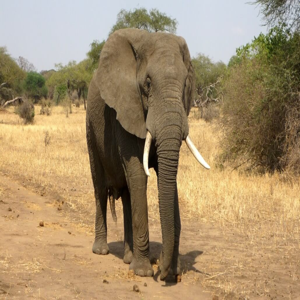

📝 Text input: I saw a beautiful elephant in the picture.


In [18]:
# Example1 text input
text_input = "I saw a beautiful elephant in the picture."

# Example image path
image_path = "data/test_images/elephant.jpg"

image = Image.open(image_path)
display(image.resize((300, 300)))
print("📝 Text input:", text_input)


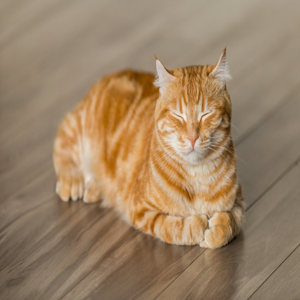

📝 Text input: Is it a dog?


In [19]:
# Example2 text input
text_input2 = "Is it a dog?"

# Example2 image path
image_path2 = "data/test_images/cat.jpg"

image2 = Image.open(image_path2)
display(image2.resize((300, 300)))
print("📝 Text input:", text_input2)

## Step 4: Run the Pipeline and Get the Result
Now, we will run the `process()` method of our multimodal pipeline. This function:
- Extracts animal entities from the given text using the NER model.
- Classifies the image using the image classifier.
- Compares both results and returns `True` if they match, `False` otherwise.

The final output will indicate whether the extracted animal entity from text matches the predicted class from the image.


In [20]:
# Run the multimodal pipeline
result = pipeline.process(text_input, image_path)

# Print final result
print("\n🔍 **Matching result:**", result)


Extracted entities: ['elephant']
📌 Predicted class: elephant

🔍 **Matching result:** True


In [21]:
# Run the multimodal pipeline
result2 = pipeline.process(text_input2, image_path2)

# Print final result
print("\n🔍 **Matching result:**", result2)

Extracted entities: ['dog']
📌 Predicted class: cat

🔍 **Matching result:** False


## Step 6: Edge Cases

Case1: Empty or nonsensical text input (e.g., "" or "Hello, how are you?")

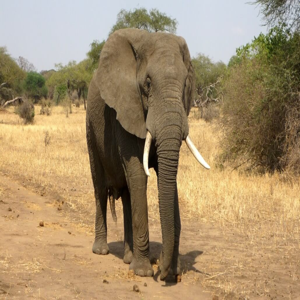

📝 Text1 input:  
Extracted entities: []
⚠️ No animal entities found in the text.

🔍 **Matching result for text1:** False
📝 Text2 input: How are you?
Extracted entities: []
⚠️ No animal entities found in the text.

🔍 **Matching result for text2:** False


In [22]:
# Example1 text input
text_input1 = " "
text_input2 = "How are you?"

# Example image path
image_path = "data/test_images/elephant.jpg"

image = Image.open(image_path)
display(image.resize((300, 300)))
print("📝 Text1 input:", text_input1)
# Run the multimodal pipeline
result = pipeline.process(text_input1, image_path)

# Print final result
print("\n🔍 **Matching result for text1:**", result)

print("📝 Text2 input:", text_input2)
# Run the multimodal pipeline
result = pipeline.process(text_input2, image_path)

# Print final result
print("\n🔍 **Matching result for text2:**", result)


Case2: Unsupported file format (e.g., .txt or corrupted image)

In [23]:
# Example1 text input
text_input = "I see a cat."

# Example image path
image_path = "data/test_images/doc.txt"
print("📝 Text input:", text_input)
# Run the multimodal pipeline
result = pipeline.process(text_input, image_path)

# Print final result
print("\n🔍 **Matching result:**", result)

📝 Text input: I see a cat.
Extracted entities: ['cat']
⚠️ Error: Invalid image format detected.

🔍 **Matching result:** False


/home/oks/VSCode_Projects/ml-test-vision-nlp/NER_ImageClassification/src/image_classifier_model.py:288: UserWarning: ⚠️ Warning: 'data/test_images/doc.txt' is not an image file. Please provide a valid image.
  warnings.warn(f"⚠️ Warning: '{image_path}' is not an image file. Please provide a valid image.")


## Step 7: Conclusion
- We successfully implemented and tested a multimodal pipeline combining text-based NER and image classification.
- The model extracts animal entities from the text and verifies them with the classified image.
- The pipeline can be further improved by training on a larger image dataset and adding an out-of-distribution (OOD) detection mechanism. 
- We can explore more powerful models for image recognition to enhance performance, such as advanced architectures like ResNet (e.g., ResNet-101, or ResNet-152) or Vision Transformers (ViTs).
- Additionally, expanding the NER dataset and testing it on a more complex and diverse set of examples will improve the robustness and accuracy of the text-based entity extraction.